In [0]:
from google.colab import drive 
drive.mount('/content/gdrive') 


In [0]:
# model.py

import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        #self.model = models.alexnet(pretrained=True)
        #self.model = models.googlenet(pretrained=True)
        #self.model = models.densenet169(pretrained=True)
        self.model = models.densenet121(pretrained=True)
        #self.model = models.densenet161(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(1024, 1)
        #self.classifier = nn.Linear(256, 1)

    # change this to adapt to different networks
    def forward(self, x):
        print('x size', x.size())
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        #x = torch.squeeze(x)
        print('x size', x.size())
        x = self.model.features(x)
        print('x size', x.size())
        # make sure that gap returns size 256
        x = self.gap(x).view(x.size(0), -1)
        print('x size', x.size())
        #print('x size', x.size())
        x = torch.max(x, 0, keepdim=True)[0]
        print('x size', x.size())
        #print('x size max', x.size())
        x = self.classifier(x)
        print('x size', x.size())
        return x

In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu

        self.transformbool = transformbool
        self.transforms = torchvision.transforms.Compose([
        #    torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        #    torchvision.transforms.RandomHorizontalFlip(p=1.0),
        #    torchvision.transforms.RandomRotation((20,20), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            #torchvision.transforms.Resize((224,224)),
        #    torchvision.transforms.ToTensor()
        
            mt_transforms.CenterCrop2D((200,200)),
            mt_transforms.RandomAffine(degrees = 0.0, scale = (1, 1), translate=(0,0)),
            mt_transforms.ToTensor()

         ])
        
        self.train_transforms = torchvision.transforms.Compose([
            mt_transforms.Resample(0.25, 0.25),
            mt_transforms.ElasticTransform(alpha_range=(40.0, 60.0),
                                           sigma_range=(2.5, 4.0),
                                           p=0.3),
            mt_transforms.ToTensor()]
        )
        
        label_dict = {}
        self.paths = []
        print(datadirs)

        for i, line in enumerate(open('metadata.csv').readlines()):
            if i == 0:
                continue
            line = line.strip().split(',')
            path = line[10]
            label = line[2]
            label_dict[path] = int(int(label) > diagnosis)

        for dir in datadirs:
            for file in os.listdir(dir):
                self.paths.append(dir+'/'+file)

        self.labels = [label_dict[path[6:]] for path in self.paths]

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

      
    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        path = self.paths[index]
        with open(path, 'rb') as file_handler: # Must use 'rb' as the data is binary
            vol = pickle.load(file_handler).astype(np.int32)
        
        # crop middle
        pad = int((vol.shape[2] - INPUT_DIM)/2)
        #print('pad', pad)
        vol = vol[:,pad:-pad,pad:-pad]
        #vol = vol[pad:-pad,pad:-pad,:]
  
        # see if theres a way to reformat an image from 196 to 224 
        # something called interpolate, scikit image. 
        # consider scipy zoom too?
        problemflag = False

        if not(vol.shape[1] == 224) or not(vol.shape[2] == 224):
          #print('problem vol shape', vol.shape)
          delta_1 = (INPUT_DIM - vol.shape[1]) // 2
          delta_2 = (INPUT_DIM - vol.shape[2]) // 2
          padding = (delta_1, delta_2)
          new_vol = np.zeros((vol.shape[0], 224, 224), dtype=np.int32)
          for slice in range(vol.shape[0]):
            vol_slice = vol[slice,:,:]
            img_slice = PIL.Image.fromarray(vol_slice)
            new_vol[slice,:,:] = np.array(PIL.ImageOps.fit(img_slice, [224, 224]), dtype='i')
          vol = new_vol  
          vol.astype(np.int32)
          problemflag = True
          #print('vol shape', vol.shape)
          #print('vol type', vol.dtype)

        #MEAN = np.mean(vol)
        #STDDEV = np.std(vol)

        # standardize
        #vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        #ver_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-20, 20)
        #uni_noise = np.random.rand(1)

        if ran_rot < 0.5:
          randomangle = 0

        #if uni_noise < 0.5:
        #  noise_array = np.random.uniform(0.9,1.1,224*224)
        #  noise_array.resize((224,224))
          
        #  vol = 

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True
            #randomangle = np.random.uniform(-20,20)
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)),
            #torchvision.transforms.RandomVerticalFlip(p=(ver_flip < 0.5)), 
            torchvision.transforms.RandomRotation((randomangle,randomangle), resample=PIL.Image.BILINEAR),
            #torchvision.transforms.RandomCrop((224,224),pad_if_needed=True),
            torchvision.transforms.ToTensor()
        ])

        """
        # see if this transform policy can take in a 3d volume
        #vol = np.asarray(vol).astype(np.uint8)
        # save the 15th slice to see if transformation happened
        #print('volume mean', np.mean(vol, axis=0))
        #save_fig = PIL.Image.fromarray(np.uint8(np.array(vol[15,:,:] * 255)))
        save_fig = PIL.Image.fromarray(np.uint8(np.array(vol[15,:,:])))
        save_fig = save_fig.convert("L")
        newpath = str(path).replace('/', ' ')
        file_name = "path" + newpath + " transform" + str(flag) + " angle" + str(round(randomangle)) + "_0.png"
        save_path = Path(rundir) / "images1" /  file_name
        save_fig.save(save_path)
        """

        #vol = vol.transpose(2,1,0)
        #print('vol shape', vol.shape)
        #print('vol sum', np.sum(vol))

        #print('vol type', vol.dtype)
        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))


        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL

        """
        save_fig = PIL.Image.fromarray(np.uint8(np.array(vol[15,:,:])))
        save_fig = save_fig.convert("L") 
        #save_fig.show()
        #file_name = f'path{path}_transform{flag}_angle{randomangle:0.4f}'
        newpath = str(path).replace('/', ' ')
        file_name = "path" + newpath + " transform" + str(flag) + " angle" + str(round(randomangle)) + "_1.png"
        save_path = Path(rundir) / "images2" /  file_name
        save_fig.save(save_path)

        if problemflag:
          save_fig = PIL.Image.fromarray(np.uint8(np.array(vol[15,:,:])))
          save_fig = save_fig.convert("L") 
          #save_fig.show()
          #file_name = f'path{path}_transform{flag}_angle{randomangle:0.4f}'
          newpath = str(path).replace('/', ' ')
          file_name = "path" + newpath + " transform" + str(flag) + " angle" + str(round(randomangle)) + "_1.png"
          save_path = Path(rundir) / "problems" /  file_name
          save_fig.save(save_path)

        """  
        # normalize
        # problems with the normalization, fix
        # vol = (vol - MEAN) / STDDEV


        #print('vol1', vol.shape)

        #print('vol shape', vol.shape)

        # convert to RGB
        #vol = np.stack((vol,)*3, axis=1)
        #print('vol2', vol.shape)

        #new_vol = self.transforms(vol).float()
        #print('new_vol', new_vol.shape)

        #assert(1==2)
        #if self.transformbool:
        #  vol = np.mean(self.transforms(vol).float(), axis=(0,1))

        """
        save_fig = PIL.Image.fromarray(np.uint8(np.array(vol[15,:,:])))
        save_fig = save_fig.convert("L")
        #save_fig.show()
        #file_name = f'path{path}_transform{flag}_angle{randomangle:0.4f}'
        newpath = str(path).replace('/', ' ')
        file_name = "path" + newpath + " transform" + str(flag) + " angle" + str(round(randomangle)) + "_2.png"
        save_path = Path(rundir) / "images5" /  file_name
        save_fig.save(save_path)
        """


        vol = np.stack((vol,)*3, axis=1)

        print('vol shape', vol.shape)

        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])
        #print('vol tensor shape', vol_tensor.shape)
        #print('label_tensor shape', label_tensor.shape)
        #assert(1==3)
        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(self, diagnosis, use_gpu=True):

    #vol_list = ['vol01', 'vol02', 'vol03', 'vol04', 'vol05', 'vol06', 'vol07', 'vol08', 'vol09', 'vol10']
    #vol_ind = [0,1,2,3,4,5,6,7,8,9]
    
    #train_ind = sample(vol_ind, 6)
    #train_dirs = [vol_list[i] for i in train_ind]

    #val_test_ind = [index for index in vol_ind if index not in train_ind]
    #val_ind = sample(val_test_ind, 2)
    #valid_dirs = [vol_list[i] for i in val_ind]

    #test_ind = [index for index in val_test_ind if index not in val_ind]
    #test_dirs = [vol_list[i] for i in test_ind]
    train_dirs = ['vol08','vol04','vol03','vol09','vol06','vol07']
    valid_dirs = ['vol10','vol05']
    test_dirs = ['vol01','vol02']

    batchsize = 1
    numworkers = 4
    
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_dirs, diagnosis, use_gpu, True)
    valid_dataset = Dataset(valid_dirs, diagnosis, use_gpu, False)
    test_dataset = Dataset(test_dirs, diagnosis, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)

    return train_loader, valid_loader, test_loader


In [0]:


# evaluate.py

import argparse
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

from sklearn import metrics
from torch.autograd import Variable

#from loader import load_data
#from model import MRNet

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_path', type=str, required=True)
    parser.add_argument('--split', type=str, required=True)
    parser.add_argument('--diagnosis', type=int, required=True)
    parser.add_argument('--gpu', action='store_true')
    return parser

def run_model(model, loader, train=False, optimizer=None):
    preds = []
    labels = []

    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.
    num_batches = 0

    for batch in loader:
        if train:
            optimizer.zero_grad()

        vol, label = batch
        if loader.dataset.use_gpu:
            vol = vol.cuda()
            label = label.cuda()
        vol = Variable(vol)
        label = Variable(label)

        logit = model.forward(vol)

        loss = loader.dataset.weighted_loss(logit, label)
        total_loss += loss.item()

        pred = torch.sigmoid(logit)
        pred_npy = pred.data.cpu().numpy()[0][0]
        label_npy = label.data.cpu().numpy()[0][0]

        preds.append(pred_npy)
        labels.append(label_npy)

        if train:
            loss.backward()
            optimizer.step()
        num_batches += 1

    avg_loss = total_loss / num_batches

    fpr, tpr, threshold = metrics.roc_curve(labels, preds)
    auc = metrics.auc(fpr, tpr)

    return avg_loss, auc, preds, labels

def evaluate(split, model_path, diagnosis, use_gpu):
    train_loader, valid_loader, test_loader = load_data(diagnosis, use_gpu)

    model = MRNet()
    state_dict = torch.load(model_path, map_location=(None if use_gpu else 'cpu'))
    model.load_state_dict(state_dict)

    if use_gpu:
        model = model.cuda()

    if split == 'train':
        loader = train_loader
    elif split == 'valid':
        loader = valid_loader
    elif split == 'test':
        loader = test_loader
    else:
        raise ValueError("split must be 'train', 'valid', or 'test'")

    loss, auc, preds, labels = run_model(model, loader)

    print(f'{split} loss: {loss:0.4f}')
    print(f'{split} AUC: {auc:0.4f}')

    return preds, labels

#if __name__ == '__main__':
#    args = get_parser().parse_args()
#   evaluate(args.split, args.model_path, args.diagnosis, args.gpu)

In [0]:
# train.py

import argparse
import json
import numpy as np
import os
import torch

from datetime import datetime
from pathlib import Path
from sklearn import metrics

#from evaluate import run_model
#from loader import load_data
#from model import MRNet

def train(rundir, diagnosis, epochs, learning_rate, use_gpu):
    val_auc_array = list()
    train_auc_array = list()
    train_loader, valid_loader, test_loader = load_data(diagnosis, use_gpu)
    
    model = MRNet()
    
    if use_gpu:
        model = model.cuda()

    # modify the code in this
    # try with RAdam
    # grid search?
    # can try without weight decay
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=.01)
    #optimizer = torch.optim.AdamW(model.parameters(), learning_rate, weight_decay=0.01)

    # patience too low (after 5 epochs, if AUC hasnt improved, slash learning rate .3), which is why high learning rate seems to work better
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.3, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        print(f'train loss: {train_loss:0.4f}')
        print(f'train AUC: {train_auc:0.4f}')

        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        print(f'valid loss: {val_loss:0.4f}')
        print(f'valid AUC: {val_auc:0.4f}')
        val_auc_array.append(val_auc)
        train_auc_array.append(train_auc)
        
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

            file_name = f'val{val_loss:0.4f}_train{train_loss:0.4f}_epoch{epoch+1}'
            save_path = Path(rundir) / file_name

            # dont need to save stuff for now, model is too shitty
            torch.save(model.state_dict(), save_path)
            #if epoch == (epochs-1):
            #  print('model saved at', str(save_path))
            #  torch.save(model.state_dict(), save_path)
            
    return val_auc_array, train_auc_array

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--rundir', type=str, required=True)
    parser.add_argument('--diagnosis', type=int, required=True)
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--gpu', action='store_true')
    parser.add_argument('--learning_rate', default=1e-05, type=float)
    parser.add_argument('--weight_decay', default=0.01, type=float)
    parser.add_argument('--epochs', default=50, type=int)
    parser.add_argument('--max_patience', default=5, type=int)
    parser.add_argument('--factor', default=0.3, type=float)
    return parser

#if __name__ == '__main__':
#    args = get_parser().parse_args()
    
#    np.random.seed(args.seed)
#    torch.manual_seed(args.seed)
#    if args.gpu:
#        torch.cuda.manual_seed_all(args.seed)

#    os.makedirs(args.rundir, exist_ok=True)
    
#    with open(Path(args.rundir) / 'args.json', 'w') as out:
#        json.dump(vars(args), out, indent=4)

#    train(args.rundir, args.diagnosis, args.epochs, args.learning_rate, args.gpu)


In [0]:
import os
%cd "/content/gdrive/My Drive/thesis/Data/vols"

#data path
train_path = "/content/gdrive/My Drive/thesis/Data/train"
data_path = "/content/gdrive/My Drive/thesis/Data/vols"
#train_meniscus_csv_path = data_path + '/train-meniscus.csv'

gpu = True
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


#learningrate = 5e-05
epochs = 150
diagnosis = 1
rundir = data_path

if gpu:
  torch.cuda.manual_seed_all(seed)

# larger learning rates
learn1 = 0.0001
learn2 = 0.0001
learn3 = 0.0001
learn4 = 0.0001
learn5 = 0.0001

varray1, tarray1 = train(rundir, diagnosis, epochs, learn1, gpu)
#varray2, tarray2 = train(rundir, diagnosis, epochs, learn2, gpu)
#varray3, tarray3 = train(rundir, diagnosis, epochs, learn3, gpu)
#varray4, tarray4 = train(rundir, diagnosis, epochs, learn4, gpu)
#varray5, tarray5 = train(rundir, diagnosis, epochs, learn5, gpu)

varray2, tarray2 = varray1, tarray1
varray3, tarray3 = varray1, tarray1
varray4, tarray4 = varray1, tarray1
varray5, tarray5 = varray1, tarray1

def display_line(x_length, lr1, y1, lr2, y2, lr3, y3, lr4, y4, lr5, y5, title, xlabel, ylabel):
  plt.figure(0)
  # see if we can set axis later
  #ax = plt.axis()
  #ax.set(xlim = (np.min(x),np.max(x)), option='tight')
  plt.title(title)
  plt.plot(np.arange(x_length), y1, label=str(lr1))
  plt.plot(np.arange(x_length), y2, label=str(lr2))
  plt.plot(np.arange(x_length), y3, label=str(lr3))
  plt.plot(np.arange(x_length), y4, label=str(lr4))
  plt.plot(np.arange(x_length), y5, label=str(lr5))
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  return

display_line(epochs, learn1, varray1, learn2, varray2, learn3, varray3, learn4, varray4, learn5, varray5, "Trained AlexNet Val AUC over epochs diagnosis = " + str(diagnosis), "epoch", "Validation AUC")
display_line(epochs, learn1, tarray1, learn2, tarray2, learn3, tarray3, learn4, tarray4, learn5, tarray5, "Trained AlexNet Train AUC over epochs diagnosis = " + str(diagnosis), "epoch", "Training AUC")

/content/gdrive/My Drive/thesis/Data/vols
['vol08', 'vol04', 'vol03', 'vol09', 'vol06', 'vol07']
['vol10', 'vol05']
['vol01', 'vol02']


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 23.0MB/s]


starting epoch 1. time passed: 0:00:00.000013
vol shape (33, 3, 224, 224)
vol shape (32, 3, 224, 224)
vol shape (30, 3, 224, 224)
vol shape (32, 3, 224, 224)
vol shape (30, 3, 224, 224)
vol shape (32, 3, 224, 224)
vol shape (32, 3, 224, 224)
vol shape (32, 3, 224, 224)
vol shape (32, 3, 224, 224)
vol shape (31, 3, 224, 224)
vol shape (32, 3, 224, 224)


KeyboardInterrupt: ignored

In [0]:

#evaluate('test', 'val0.0175_train0.0139_epoch50', 1, True)

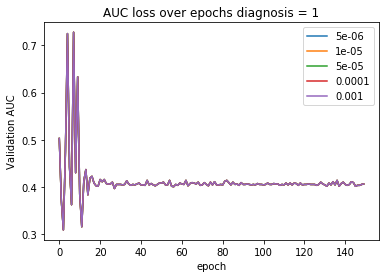

In [0]:

def display1_line(x_length, lr1, y1, lr2, y2, lr3, y3, lr4, y4, lr5, y5, title, xlabel, ylabel):
  plt.figure(0)
  # see if we can set axis later
  #ax = plt.axis()
  #ax.set(xlim = (np.min(x),np.max(x)), option='tight')
  plt.title(title)
  plt.plot(np.arange(x_length), y1, label=str(lr1))
  plt.plot(np.arange(x_length), y2, label=str(lr2))
  plt.plot(np.arange(x_length), y3, label=str(lr3))
  plt.plot(np.arange(x_length), y4, label=str(lr4))
  plt.plot(np.arange(x_length), y5, label=str(lr5))
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  return

display1_line(epochs, 5e-06, varray1, 1e-05, varray2, 5e-05, varray3, 1e-04, varray4, 1e-03, varray5, "AUC loss over epochs diagnosis = " + str(diagnosis), "epoch", "Validation AUC")

In [0]:
# notes from ben
# get rid of double standardization, dont have RGB channels all have same information, make AlexNet take 1 channel instead of 3. 
# try to dissect images into two camps, 3.0T and 1.5T.
# Then we can try to change into DenseNets. 

In [0]:
p-values[rot, crop, shift] = [0.3, 0.4, 0.5]

for every image in folder:
  load image

  if random number generator < p-values rot:
    image = rotate image (by x degrees)
  if random number generator < p-values crop:
    image = crop image (by x,y values)
  if random number generator < p-values shift:
    image = shift image (by x values in y direction)

  convert image into tensor for processing
  send image to training batch, grab next image

SyntaxError: ignored

In [0]:
define initial state of model
(Lets say a simple model of 3 layers, with ReLU activation functions and
 down-sampling method of max pool. Input image is 256x256)
features = Sequential model: 
  Layer: Convolutional 2 dimensional (256 input, 128 output, padding = 2)
  Activation Function: ReLU
  Down-Sample: maxpool
  Layer: Convolutional 2 dimensional (128 input, 64 output, padding = 2)
  Activation Function: ReLU
  Down-Sample: maxpool
  Layer: Convolutional 2 dimensional (64 input, 32 output, padding = 2)
  Activation Function: ReLU
  Down-Sample: maxpool

  Layer: Softmax (to convert a 32x32 matrix to probability distribution used to classify)
